# 3T$ milestone

There are 3 companies in the history that have reached a market cap of 3 trillion dollars: `Apple`, `Microsoft` and `NVIDIA`.

But do you know how much time did they take to reach this milestone? Let's check it using `polars` and `plotnine`!

## Imports, constants and paths

In [1]:
import polars as pl

from pathlib import Path

from plotnine import (
    # Generic
    ggplot,
    aes,
    # geoms
    geom_line,
    geom_text,
    geom_label,
    geom_segment,
    geom_vline,
    # misc
    element_blank,
    element_text,
    arrow,
    # scales
    scale_x_continuous,
    scale_y_continuous,
    scale_color_manual,
    # themes
    labs,
    theme_538,
    theme,
)

In [2]:
DATA_PATH = Path('..', 'data', '3t')
list(DATA_PATH.glob('*'))

[PosixPath('../data/3t/sp500_companies.csv'),
 PosixPath('../data/3t/MSFT.csv'),
 PosixPath('../data/3t/NVDA.csv'),
 PosixPath('../data/3t/AAPL.csv')]

## Data

This dataset contains information about S&P companies. We'll use it to:
- Get the company name from the ticket
- Calculate the number of shares based on the current market cap and its price

In [3]:
df_companies = (
    pl
    .scan_csv(
        DATA_PATH / 'sp500_companies.csv',
        infer_schema_length=None,
    )
    .select(
        pl.col('Symbol').alias('company'),
        'Shortname',
        pl
        .col('Marketcap')
        .truediv(pl.col('Currentprice'))
        .alias('number_of_shares'),
    )
    .collect()
)
df_companies.head()

company,Shortname,number_of_shares
str,str,f64
"""MSFT""","""Microsoft Corporation""",7.4323e9
"""AAPL""","""Apple Inc.""",1.5334e10
"""NVDA""","""NVIDIA Corporation""",2.4598e10
"""GOOGL""","""Alphabet Inc.""",1.2398e10
"""GOOG""","""Alphabet Inc.""",1.2310e10


We'll load historical stock prices from Apple, Microsoft and NVIDIA. We'll keep the ticket, the adjusted closed price for a specific date, and the date itself

In [4]:
df = pl.LazyFrame()
for file in DATA_PATH.glob('*[!sp500_companies].csv'):
    df = (
        pl
        .concat([
            df,
            pl
            .scan_csv(
                file,
                try_parse_dates=True,
            )
            .select(
                pl.col('Date'),
                pl.col('Adj Close'),
                pl.lit(file.stem).alias('company'),
            )
        ])
    )

df = df.collect()
df.head()

Date,Adj Close,company
date,f64,str
1986-03-13,0.060055,"""MSFT"""
1986-03-14,0.062199,"""MSFT"""
1986-03-17,0.063272,"""MSFT"""
1986-03-18,0.061663,"""MSFT"""
1986-03-19,0.060591,"""MSFT"""


## Preprocessing and plot

/Users/diego/Library/Caches/pypoetry/virtualenvs/plotnine-contest-FuPsS-QY-py3.10/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 2513 rows containing missing values.


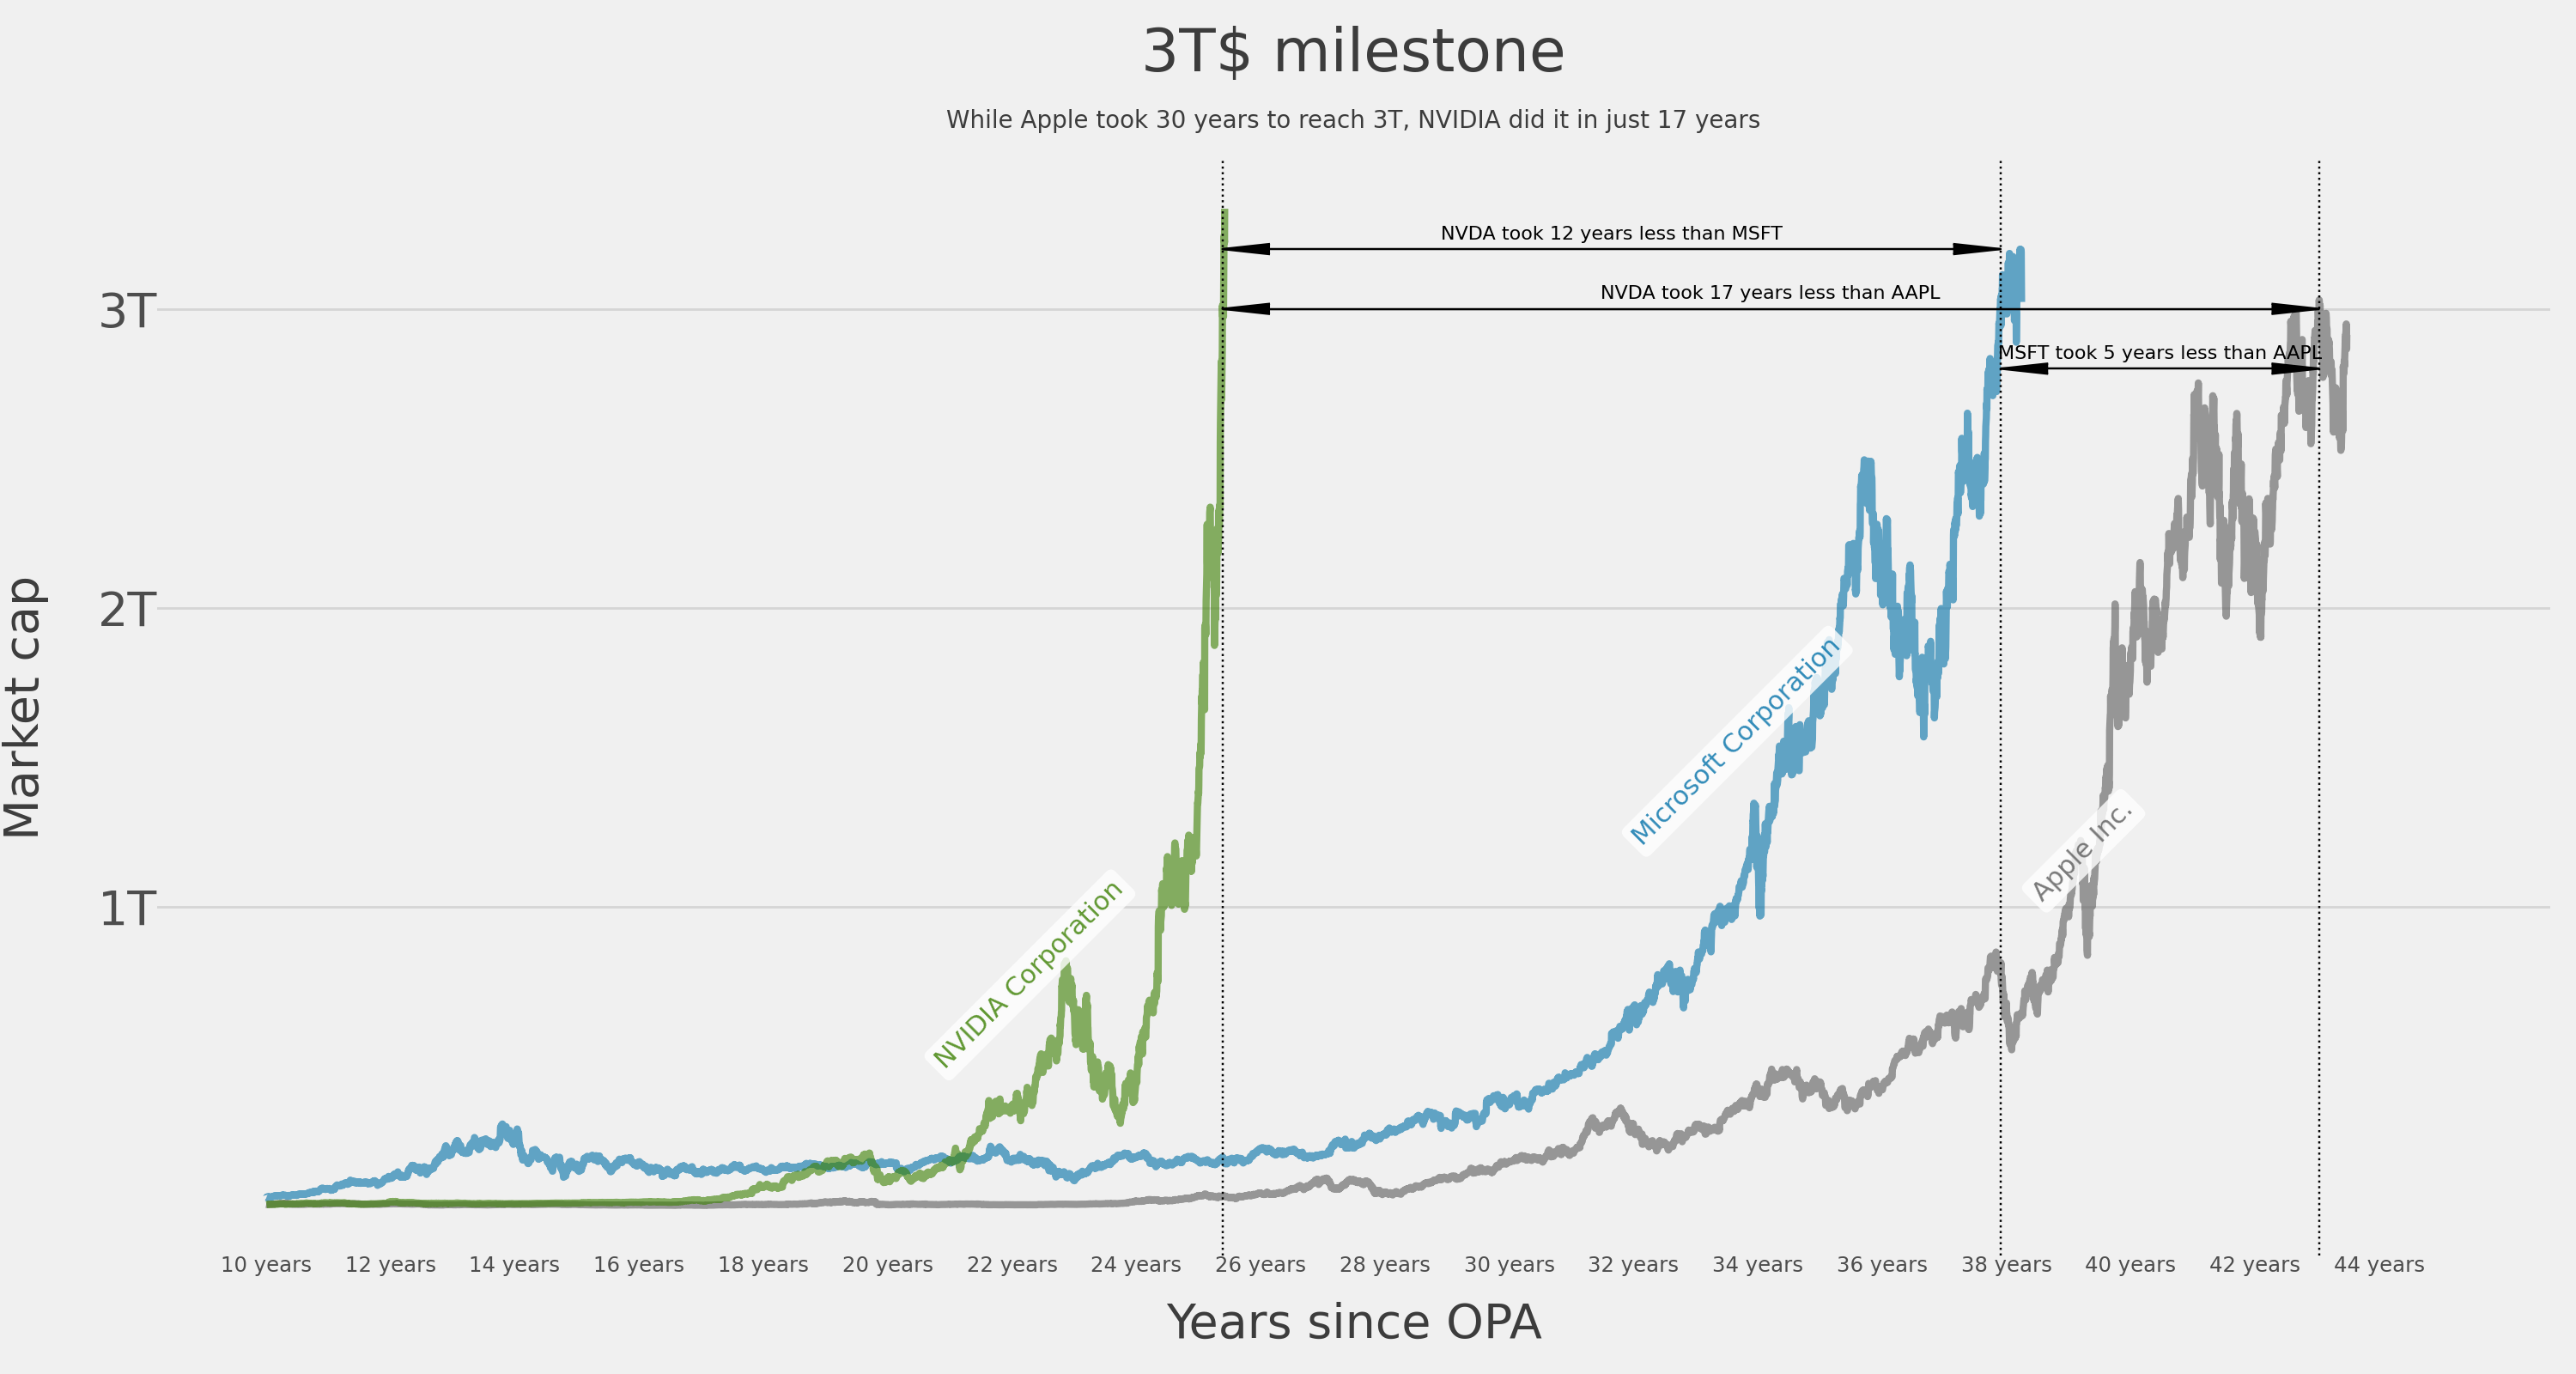

In [8]:
(
    df
    # Get the number of shares and the name of the company
    .join(
        df_companies,
        how='left',
        on='company',
    )
    # Calculate the market cap of the company at each date
    .with_columns(
        pl.col('Adj Close').mul(pl.col('number_of_shares')).alias('marketcap'),
    )
    # The OPA from each company was in a different date, so we need to normalize it
    # We'll calculate a rank (taking into account weekends and holidays): years since OPA
    .pipe(
        lambda x: (
            x
            .join(
                # For each company, get a date range from the OPA to the current date
                x
                .group_by('company')
                .agg(
                    pl.col('Date').min().alias('start'),
                    pl.col('Date').max().alias('end'),
                )
                .select(
                    'company',
                    pl
                    .date_ranges(
                        start=pl.col('start'),
                        end=pl.col('end'),
                        interval='1d',
                        closed='both',
                    )
                    .alias('Date'),
                )
                .explode('Date')
                # Calculate the rank itself
                .with_columns(
                    pl.col('Date').cum_count().sub(1).cast(pl.Int64).over('company').alias('rank'),
                )
                # Transform the rank to years
                .with_columns(
                    pl.col('rank').truediv(365),
                ),
                how='left',
                on=('company', 'Date'),
            )
        )
    )
    # Let's plot!
    .pipe(
        lambda x: (
            ggplot(
                x,
                aes(
                    x='rank',
                    y='marketcap',
                    color='company',
                )
            )
            # Market cap lines
            + geom_line(
                show_legend=False,
                size=1.7,
                alpha=.6,
            )
            # Label containing the name of the company
            + geom_label(
                data=(
                    x
                    .filter(
                        pl.col('rank')
                        # We want to place it at ~90pct of each line
                        == (pl.col('rank').quantile(.9).over('company')),
                    )
                ),
                mapping=aes(
                    x='rank',
                    y='marketcap',
                    label='Shortname',
                ),
                ha='right',
                nudge_x=1,
                angle=45,
                alpha=.8,
                label_size=0.0,
                show_legend=False,
            )
            # Differences among companies to reach 3T (segment)
            + geom_segment(
                data=(
                    # For each company, we need to know when it reached 3T (or higher)
                    x
                    .filter(
                        pl
                        .col('Date')
                        .eq(
                            pl
                            .col('Date')
                            .filter(pl.col('marketcap') >= 3e12)
                            .min()
                            .over('company')
                        ),
                    )
                    .select(
                        'company',
                        pl.col('rank').alias('start'),
                    )
                    # To calculate the differences among companies, we need to get every combination
                    # (Apple vs Microsoft, Apple vs Nvidia, Microsoft vs Nvidia)
                    .pipe(
                        lambda x: (
                            x
                            .join(
                                x,
                                how='cross',
                                suffix='_end',
                            )
                        )
                    )
                    # And filter only the combination where the start is before the end
                    .filter(
                        pl.col('start') < pl.col('start_end')
                    )
                    # Finally, generate the label that we want to show
                    .with_columns(
                        pl
                        .format(
                            '{} took {} years less than {}',
                            pl.col('company'),
                            (pl.col('start_end') - pl.col('start')).cast(pl.Int8),
                            pl.col('company_end'),
                        )
                        .alias('message'),
                        # Also, we generate y_axis with some space, so segments don't overlap
                        pl.Series(name='y_axis', values=[2.8e12, 3.2e12, 3e12]),
                    )
                ),
                mapping=aes(
                    x='start',
                    xend='start_end',
                    y='y_axis',
                    yend='y_axis',
                ),
                color='black',
                arrow=arrow(angle=10, ends='both', type='closed', length=.1),
            )
            # Differences among companies to reach 3T (text)
            + geom_text(
                data=(
                    x
                    .filter(
                        pl
                        .col('Date')
                        .eq(
                            pl
                            .col('Date')
                            .filter(pl.col('marketcap') > 3e12)
                            .min()
                            .over('company')
                        ),
                    )
                    .select(
                        'company',
                        pl.col('rank').alias('start'),
                    )
                    .pipe(
                        lambda x: (
                            x
                            .join(
                                x,
                                how='cross',
                                suffix='_end',
                            )
                        )
                    )
                    .filter(
                        pl.col('start') < pl.col('start_end')
                    )
                    .with_columns(
                        pl
                        .format(
                            '{} took {} years less than {}',
                            pl.col('company'),
                            (pl.col('start_end') - pl.col('start')).cast(pl.Int8),
                            pl.col('company_end'),
                        )
                        .alias('message'),
                        # We place the text in the middle of the segment
                        pl.mean_horizontal('start_end', 'start').alias('x_axis'),
                        pl.Series(name='y_axis', values=[2.8e12, 3.2e12, 3e12]) + .5e11,
                    )
                ),
                mapping=aes(
                    x='x_axis',
                    y='y_axis',
                    yend='y_axis',
                    label='message',
                ),
                color='black',
                size=8,
            )
            # Vertical lines to show when each company reached 3T
            + geom_vline(
                data=(
                    x
                    .filter(
                        pl.col('rank') == pl.col('rank').filter(pl.col('marketcap') >= 3e12).min().over('company'),
                    )
                ),
                mapping=aes(
                    xintercept='rank',
                ),
                size=.5,
                linetype='dotted',
            )
            # Show a label every 2 years (for 45 years) in X axis
            # Also, don't show the first 10 years since doesn't add information
            + scale_x_continuous(
                breaks=[
                    i // 365
                    for i in
                    range(0, 365 * 45, 365 * 2)
                ],
                limits=(10, 45),
                labels=lambda breaks: [f'{int(x)} years' for x in breaks],
            )
            # Show only trillion market cap milestones in Y axis
            + scale_y_continuous(
                breaks=[1e12, 2e12, 3e12],
                labels=lambda breaks: [f'{str(x)[0]}T' for x in breaks],
            )
            # Manual colors for each company. This is from each company palette
            # but choosing a darker color
            + scale_color_manual(
                values=[
                    '#5a5a5a', # Apple
                    '#0070a8', # Microsoft
                    '#3a7f00', # Nvidia
                ],
            )
            # Names of axis and titles
            + labs(
                x='Years since OPA',
                y='Market cap',
                title='3T$ milestone',
                subtitle='While Apple took 30 years to reach 3T, NVIDIA did it in just 17 years',
            )
            + theme_538()
            # Figure and text size
            + theme(
                figure_size=(15, 8),
                panel_grid_major_x=element_blank(),
                axis_text_y=element_text(size=20),
                axis_title=element_text(size=20),
                title=element_text(
                    hjust=.5,
                    size=25,
                ),
                plot_subtitle=element_text(size=10),
            )
        )
    )
)
